In [1]:
import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
# pio.renderers.default = 'browser'
import plotly.graph_objects as go
import sympy as sy
import scipy as sp

In [2]:
# Importando o banco de dados

notas = pd.read_excel("data/notas_fatorial.xlsx")

In [3]:
# Informações sobre as variáveis

# Informações gerais sobre o DataFrame

print(notas.info())

# Estatísticas descritiva das variáveis

print(notas.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   estudante  100 non-null    object 
 1   finanças   100 non-null    float64
 2   custos     100 non-null    float64
 3   marketing  100 non-null    float64
 4   atuária    100 non-null    float64
dtypes: float64(4), object(1)
memory usage: 4.0+ KB
None
         finanças      custos   marketing     atuária
count  100.000000  100.000000  100.000000  100.000000
mean     5.834000    4.717000    5.668000    5.314000
std      3.122749    2.455999    2.828351    2.513078
min      0.600000    1.900000    1.000000    1.700000
25%      3.100000    2.900000    3.000000    3.200000
50%      5.800000    4.000000    6.000000    5.000000
75%      9.000000    6.000000    8.000000    7.025000
max     10.000000   10.000000   10.000000   10.000000


In [4]:
# Separando somente as variáveis quantitativas do banco de dados

notas_pca = notas[["finanças", "custos", "marketing", "atuária"]]

In [5]:
# Matriz de correlações de Pearson entre as variáveis

pg.rcorr(notas_pca, method = 'pearson', upper = 'pval', 
         decimals = 4, 
         pval_stars = {0.01: '***', 0.05: '**', 0.10: '*'})

,finanças,custos,marketing,atuária
finanças,-,***,,***
custos,0.7556,-,,***
marketing,-0.0295,0.0029,-,
atuária,0.7109,0.8081,-0.0443,-


In [6]:
# Outra maneira de analisar as informações das correlações

# Matriz de correlações em um objeto "simples"

corr = notas_pca.corr()

# Gráfico interativo

fig = go.Figure()

fig.add_trace(
    go.Heatmap(
        x = corr.columns,
        y = corr.index,
        z = np.array(corr),
        text=corr.values,
        texttemplate='%{text:.4f}',
        colorscale='viridis'))

fig.update_layout(
    height = 600,
    width = 600,
    yaxis=dict(autorange="reversed"))

fig.show()

In [7]:
# Teste de Esfericidade de Bartlett

bartlett, p_value = calculate_bartlett_sphericity(notas_pca)

print(f'Qui² Bartlett: {round(bartlett, 2)}')
print(f'p-valor: {round(p_value, 4)}')

Qui² Bartlett: 191.88
p-valor: 0.0


In [8]:
# Definindo a PCA (procedimento inicial com todos os fatores possíveis)

fa = FactorAnalyzer(n_factors=4, method='principal', rotation=None).fit(notas_pca)

In [9]:
# Obtendo os eigenvalues (autovalores): resultantes da função FactorAnalyzer

autovalores = fa.get_eigenvalues()[0]

print(autovalores) # Temos 4 autovalores, pois são 4 variáveis ao todo

# Soma dos autovalores

round(autovalores.sum(), 2)

[2.51812681 1.0003793  0.29761585 0.18387804]


np.float64(4.0)

In [10]:
# Obtendo os autovalores e autovetores: ilustrando o fundamento

## Atenção: esta célula tem fins didáticos, não é requerida na FactorAnalyzer

# Parametrizando o pacote

lamda = sy.symbols('lamda')
sy.init_printing(scale=0.8)

# Especificando a matriz de correlações

matriz = sy.Matrix(corr)
polinomio = matriz.charpoly(lamda)

polinomio

# Obtendo as raízes do polinômio característico: são os autovalores

autovalores, autovetores = sp.linalg.eigh(corr)
autovalores = autovalores[::-1]

# Obtendo os autovetores para cada autovalor extraído

autovetores = autovetores[:, ::-1]

In [11]:
# Eigenvalues, variâncias e variâncias acumuladas

autovalores_fatores = fa.get_factor_variance()

tabela_eigen = pd.DataFrame(autovalores_fatores)
tabela_eigen.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_eigen.columns)]
tabela_eigen.index = ['Autovalor','Variância', 'Variância Acumulada']
tabela_eigen = tabela_eigen.T

print(tabela_eigen)

         Autovalor  Variância  Variância Acumulada
Fator 1   2.518127   0.629532             0.629532
Fator 2   1.000379   0.250095             0.879627
Fator 3   0.297616   0.074404             0.954030
Fator 4   0.183878   0.045970             1.000000


C:\Users\guilh\AppData\Local\Temp\ipykernel_12904\628219071.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




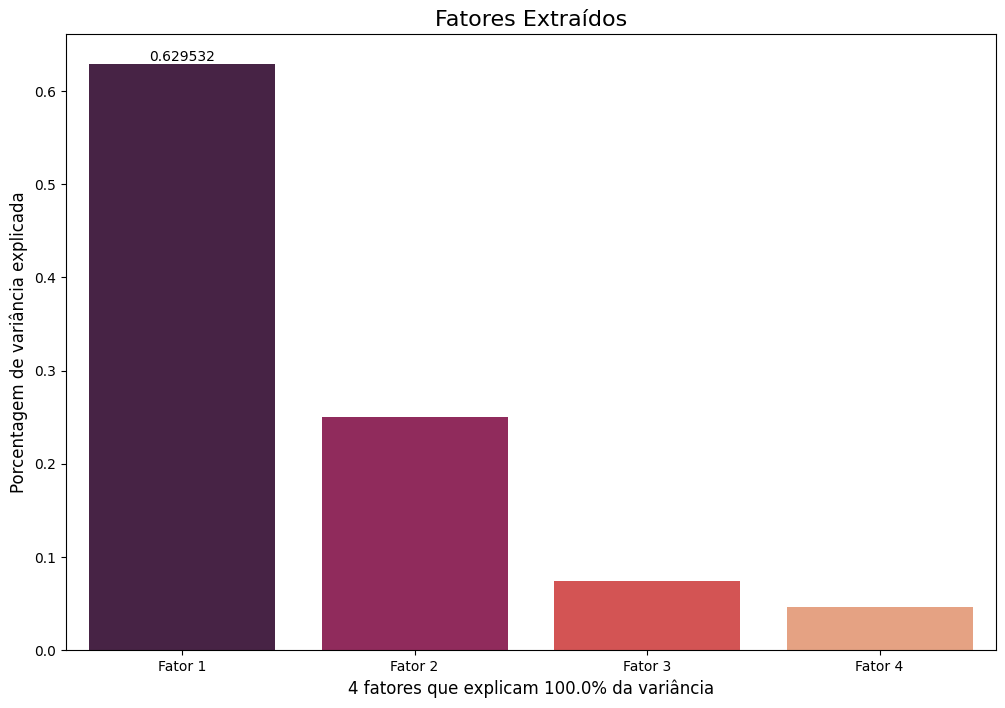

In [12]:
# Gráfico da variância acumulada dos componentes principais

plt.figure(figsize=(12,8))
ax = sns.barplot(x=tabela_eigen.index, y=tabela_eigen['Variância'], data=tabela_eigen, palette='rocket')
ax.bar_label(ax.containers[0])
plt.title("Fatores Extraídos", fontsize=16)
plt.xlabel(f"{tabela_eigen.shape[0]} fatores que explicam {round(tabela_eigen['Variância'].sum()*100,2)}% da variância", fontsize=12)
plt.ylabel("Porcentagem de variância explicada", fontsize=12)
plt.show()

In [13]:
# Determinando as cargas fatoriais

cargas_fatoriais = fa.loadings_

tabela_cargas = pd.DataFrame(cargas_fatoriais)
tabela_cargas.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_cargas.columns)]
tabela_cargas.index = notas_pca.columns

print(tabela_cargas)

            Fator 1   Fator 2   Fator 3   Fator 4
finanças   0.895398  0.007086  0.436720  0.086533
custos     0.934033  0.048581 -0.119783 -0.332978
marketing -0.042466  0.998933 -0.000358  0.018170
atuária    0.917697 -0.010133 -0.304210  0.255315


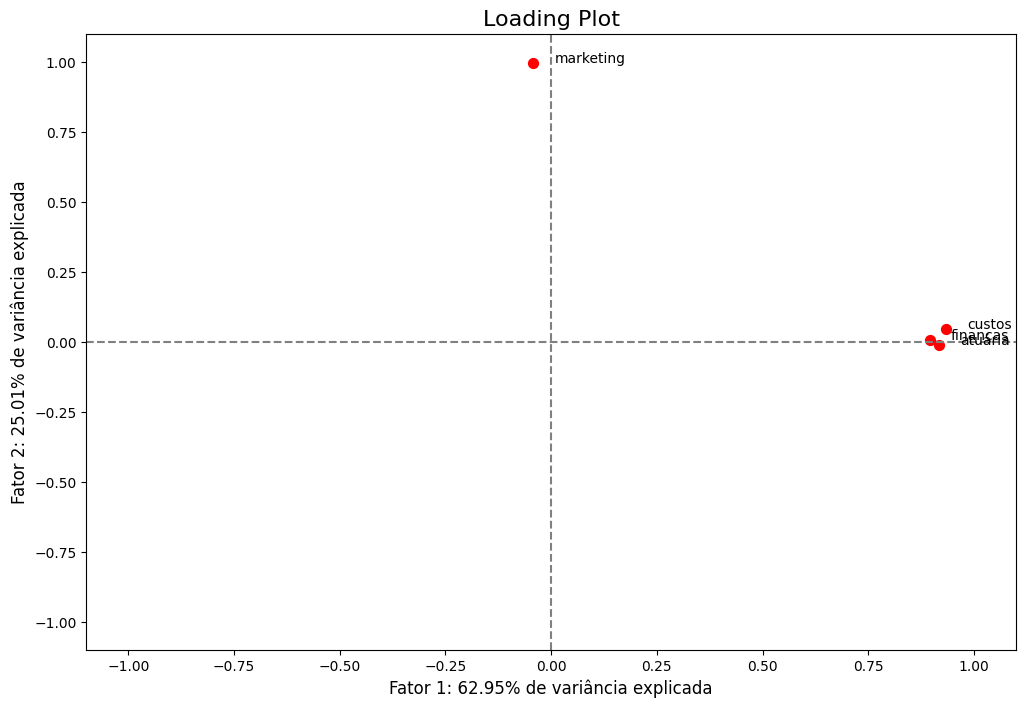

In [14]:
# Gráfico das cargas fatoriais (loading plot)

plt.figure(figsize=(12,8))
tabela_cargas_chart = tabela_cargas.reset_index()
plt.scatter(tabela_cargas_chart['Fator 1'], tabela_cargas_chart['Fator 2'], s=50, color='red')

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + 0.05, point['y'], point['val'])

label_point(x = tabela_cargas_chart['Fator 1'],
            y = tabela_cargas_chart['Fator 2'],
            val = tabela_cargas_chart['index'],
            ax = plt.gca()) 

plt.axhline(y=0, color='grey', ls='--')
plt.axvline(x=0, color='grey', ls='--')
plt.ylim([-1.1,1.1])
plt.xlim([-1.1,1.1])
plt.title("Loading Plot", fontsize=16)
plt.xlabel(f"Fator 1: {round(tabela_eigen.iloc[0]['Variância']*100,2)}% de variância explicada", fontsize=12)
plt.ylabel(f"Fator 2: {round(tabela_eigen.iloc[1]['Variância']*100,2)}% de variância explicada", fontsize=12)
plt.show()

In [15]:
# Determinando as comunalidades

comunalidades = fa.get_communalities()

tabela_comunalidades = pd.DataFrame(comunalidades)
tabela_comunalidades.columns = ['Comunalidades']
tabela_comunalidades.index = notas_pca.columns

print(tabela_comunalidades)

           Comunalidades
finanças             1.0
custos               1.0
marketing            1.0
atuária              1.0


**As comunalidade são o resultado da soma das cargas fatoriais (célula 13) elevadas ao quadrado**

*Exemplo:*
- *Finanças: 0.895398² + 0.007086² + 0.436720² + 0.086533² = 1*

In [16]:
# Extração dos fatores para as observações do banco de dados

fatores = pd.DataFrame(fa.transform(notas_pca))
fatores.columns =  [f"Fator {i+1}" for i, v in enumerate(fatores.columns)]

# Adicionando os fatores ao banco de dados

notas = pd.concat([notas.reset_index(drop=True), fatores], axis=1)

In [17]:
# Identificando os scores fatoriais

scores = fa.weights_

tabela_scores = pd.DataFrame(scores)
tabela_scores.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_scores.columns)]
tabela_scores.index = notas_pca.columns

print(tabela_scores)

            Fator 1   Fator 2   Fator 3   Fator 4
finanças   0.355581  0.007083  1.467395  0.470601
custos     0.370924  0.048562 -0.402475 -1.810861
marketing -0.016864  0.998554 -0.001204  0.098814
atuária    0.364436 -0.010129 -1.022155  1.388503


In [18]:
# Correlação entre os fatores extraídos

# A seguir, verifica-se que a correlação entre os fatores é zero (ortogonais)

pg.rcorr(notas[['Fator 1','Fator 2', 'Fator 3', 'Fator 4']],
         method = 'pearson', upper = 'pval', 
         decimals = 4, 
         pval_stars = {0.01: '***', 0.05: '**', 0.10: '*'})

,Fator 1,Fator 2,Fator 3,Fator 4
Fator 1,-,,,
Fator 2,-0.0,-,,
Fator 3,0.0,0.0,-,
Fator 4,0.0,-0.0,-0.0,-


#### Critério de Kaiser (raiz latente)
- Verificar os autovalores com valores maiores que 1
- Existem dois componentes maiores do que 1

In [19]:
# Parametrizando a PCA para dois fatores (autovalores > 1)

fa = FactorAnalyzer(n_factors=2, method='principal', rotation=None).fit(notas_pca)

In [20]:
# Eigenvalues, variâncias e variâncias acumuladas de 2 fatores

# Note que não há alterações nos valores, apenas ocorre a seleção dos fatores

autovalores_fatores = fa.get_factor_variance()

tabela_eigen = pd.DataFrame(autovalores_fatores)
tabela_eigen.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_eigen.columns)]
tabela_eigen.index = ['Autovalor','Variância', 'Variância Acumulada']
tabela_eigen = tabela_eigen.T

print(tabela_eigen)

         Autovalor  Variância  Variância Acumulada
Fator 1   2.518127   0.629532             0.629532
Fator 2   1.000379   0.250095             0.879627


In [21]:
# Determinando as cargas fatoriais

# Note que não há alterações nas cargas fatoriais nos 2 fatores!

cargas_fatoriais = fa.loadings_

tabela_cargas = pd.DataFrame(cargas_fatoriais)
tabela_cargas.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_cargas.columns)]
tabela_cargas.index = notas_pca.columns

print(tabela_cargas)

            Fator 1   Fator 2
finanças   0.895398  0.007086
custos     0.934033  0.048581
marketing -0.042466  0.998933
atuária    0.917697 -0.010133


In [22]:
# Determinando as novas comunalidades

# As comunalidades são alteradas, pois há fatores retirados da análise!

comunalidades = fa.get_communalities()

tabela_comunalidades = pd.DataFrame(comunalidades)
tabela_comunalidades.columns = ['Comunalidades']
tabela_comunalidades.index = notas_pca.columns

print(tabela_comunalidades)

           Comunalidades
finanças        0.801788
custos          0.874778
marketing       0.999670
atuária         0.842271


In [24]:
# Extração dos fatores para as observações do banco de dados

# Vamos remover os fatores obtidos anteriormente

notas = notas.drop(columns=['Fator 1', 'Fator 2', 'Fator 3', 'Fator 4'])

#  Vamos gerar novamente, agora para os 2 fatores extraídos

fatores = pd.DataFrame(fa.transform(notas_pca))
fatores.columns =  [f"Fator {i+1}" for i, v in enumerate(fatores.columns)]

# Adicionando os fatores ao banco de dados

notas = pd.concat([notas.reset_index(drop=True), fatores], axis=1)

# Note que são os mesmos, apenas ocorre a seleção dos 2 primeiros fatores!

In [25]:
# Identificando os scores fatoriais

# Não há mudanças nos scores fatoriais!

scores = fa.weights_

tabela_scores = pd.DataFrame(scores)
tabela_scores.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_scores.columns)]
tabela_scores.index = notas_pca.columns

print(tabela_scores)

            Fator 1   Fator 2
finanças   0.355581  0.007083
custos     0.370924  0.048562
marketing -0.016864  0.998554
atuária    0.364436 -0.010129


In [26]:
# Criando um ranking (soma ponderada e ordenamento)

# O ranking irá considerar apenas os 2 fatores com autovalores > 1
# A base de seleção é a tabela_eigen

notas['Ranking'] = 0

for index, item in enumerate(list(tabela_eigen.index)):
    variancia = tabela_eigen.loc[item]['Variância']

    notas['Ranking'] = notas['Ranking'] + notas[tabela_eigen.index[index]]*variancia
    
print(notas)

      estudante  finanças  custos  marketing  atuária   Fator 1   Fator 2  \
0      Gabriela       5.8     4.0        1.0      6.0  0.015232 -1.673452   
1   Luiz Felipe       3.1     3.0       10.0      2.0 -1.082468  1.510196   
2      Patrícia       3.1     4.0        4.0      4.0 -0.603231 -0.607015   
3       Gustavo      10.0     8.0        8.0      8.0  1.352586  0.891321   
4       Letícia       3.4     2.0        3.2      3.2 -0.984279 -0.926699   
..          ...       ...     ...        ...      ...       ...       ...   
95       Sheila       7.7     4.3        5.2      5.1  0.121867 -0.169227   
96        Pedro       9.0     6.0        4.0      9.8  1.220881 -0.577316   
97      Horácio       9.3     6.0        7.0      7.0  0.829146  0.499201   
98      Leandro       9.0     6.5        3.0      9.0  1.186171 -0.918969   
99       Estela       8.9     5.0        2.0      8.0  0.807290 -1.299785   

     Ranking  
0  -0.408932  
1  -0.303756  
2  -0.531564  
3   1.074410  
